In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.metrics import mean_squared_error
pd.set_option('mode.chained_assignment', None)

In [2]:
dataset = pd.read_csv("PJME_hourly.csv")
df = dataset.copy()

In [3]:
df.head()

,Datetime,PJME_MW
0,2002-12-31 01:00:00,26498.0
1,2002-12-31 02:00:00,25147.0
2,2002-12-31 03:00:00,24574.0
3,2002-12-31 04:00:00,24393.0
4,2002-12-31 05:00:00,24860.0


In [4]:
df = df.set_index("Datetime")

In [5]:
df.index =  pd.to_datetime(df.index)

In [6]:
color_pal = sns.color_palette()
color_pal

[(0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 (1.0, 0.4980392156862745, 0.054901960784313725),
 (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
 (0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
 (0.5803921568627451, 0.403921568627451, 0.7411764705882353),
 (0.5490196078431373, 0.33725490196078434, 0.29411764705882354),
 (0.8901960784313725, 0.4666666666666667, 0.7607843137254902),
 (0.4980392156862745, 0.4980392156862745, 0.4980392156862745),
 (0.7372549019607844, 0.7411764705882353, 0.13333333333333333),
 (0.09019607843137255, 0.7450980392156863, 0.8117647058823529)]

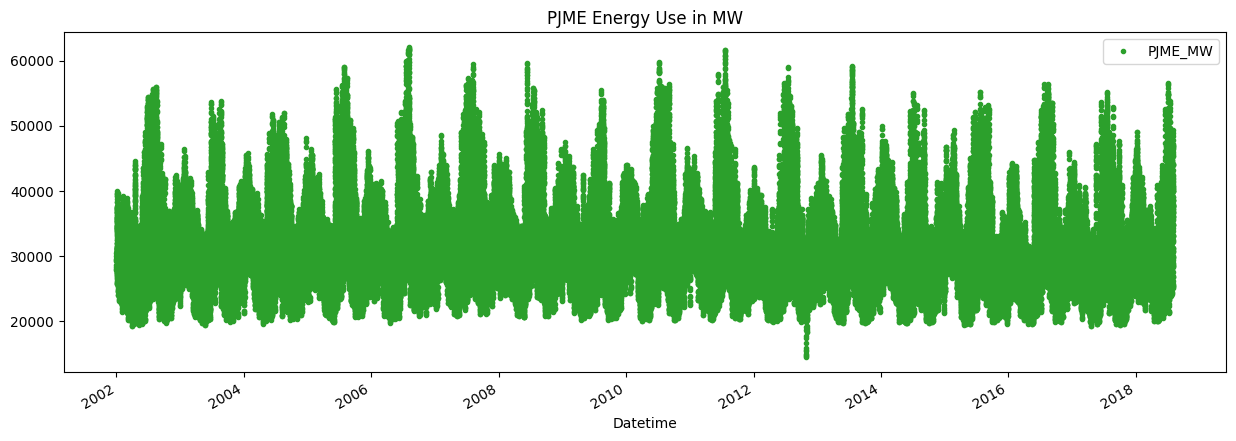

In [7]:
df.plot(style=".", figsize=(15,5), color=color_pal[2], title="PJME Energy Use in MW")
plt.show()

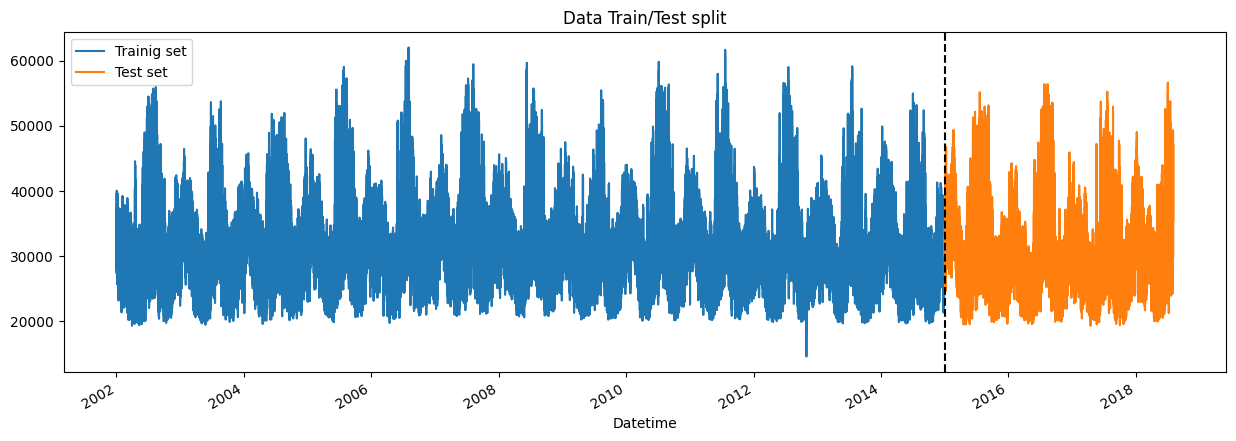

In [8]:
train = df.loc[df.index < "01-01-2015"]
test = df.loc[df.index >= "01-01-2015"]

fig, ax = plt.subplots(figsize=(15,5))
train.plot(ax=ax, label="Training set", title="Data Train/Test split")
test.plot(ax=ax, label="Test set")
ax.axvline("01-01-2015", color="black", ls="--")
ax.legend(["Trainig set", "Test set"])
plt.show()

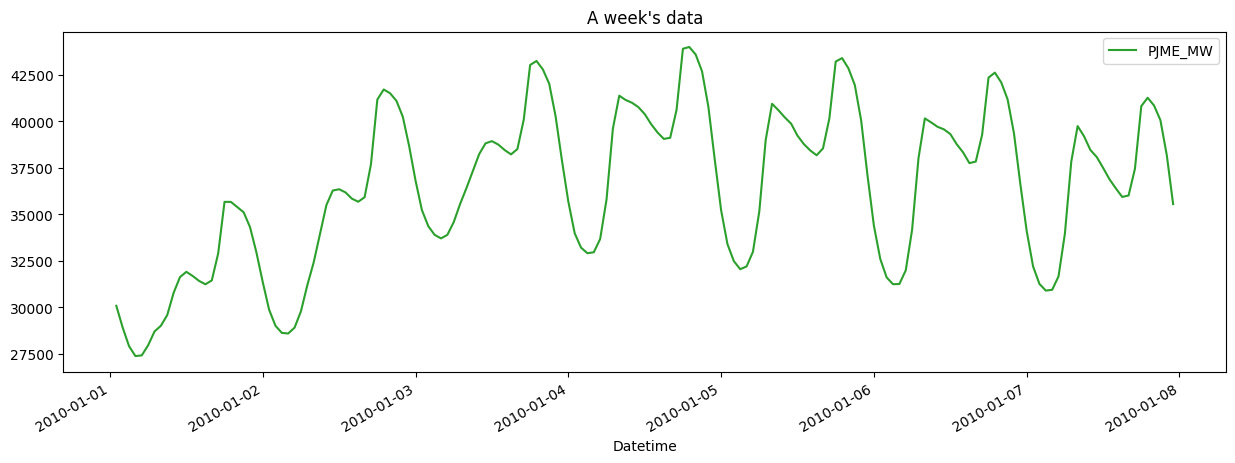

In [9]:
df.loc[(df.index > "01-01-2010") & (df.index < "01-08-2010")].plot(figsize=(15,5), color=color_pal[2], title="A week's data")
plt.show()

## Feature collection

In [10]:
def create_feature(df):
    df = df.copy()
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.day_of_week
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.day_of_year
    return df

df = create_feature(df)

## Visualize our feature/target relationship

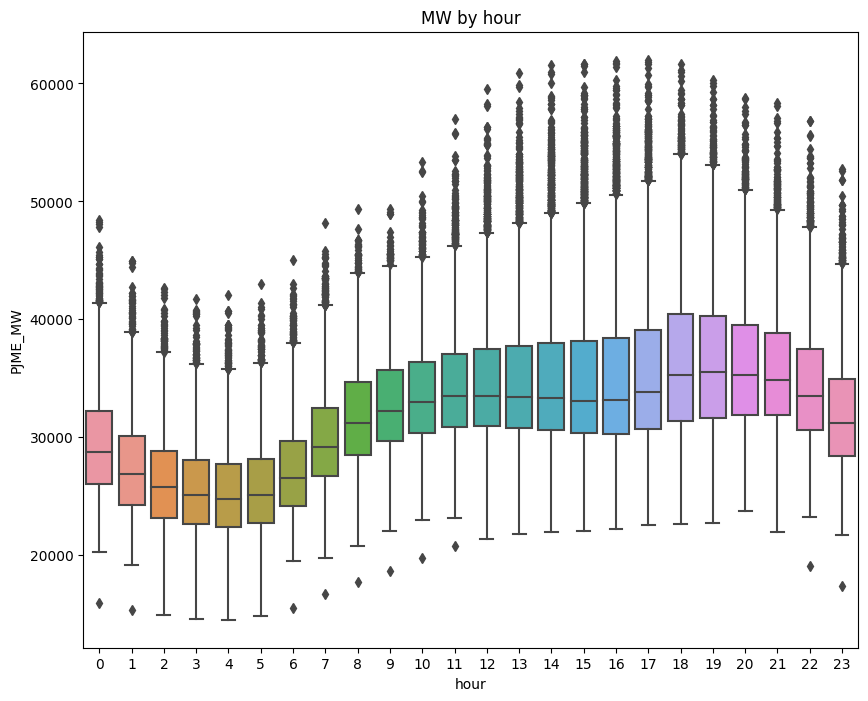

In [11]:
fig, ax = plt.subplots(figsize=(10,8))
sns.boxplot(data=df, x="hour", y="PJME_MW")
ax.set_title("MW by hour")
plt.show()

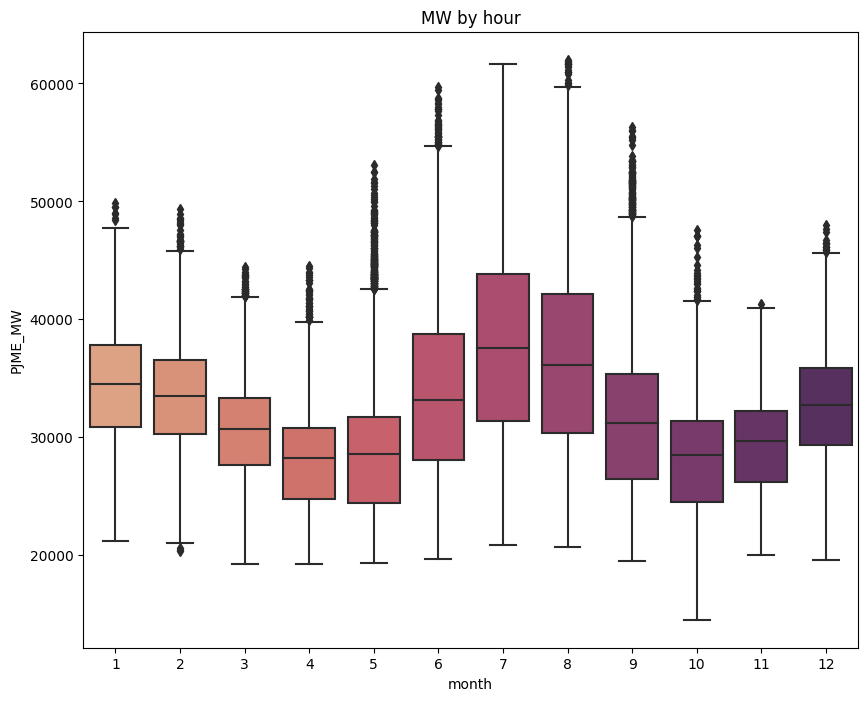

In [12]:
fig, ax = plt.subplots(figsize=(10,8))
sns.boxplot(data=df, x="month", y="PJME_MW", palette="flare")
ax.set_title("MW by hour")
plt.show()

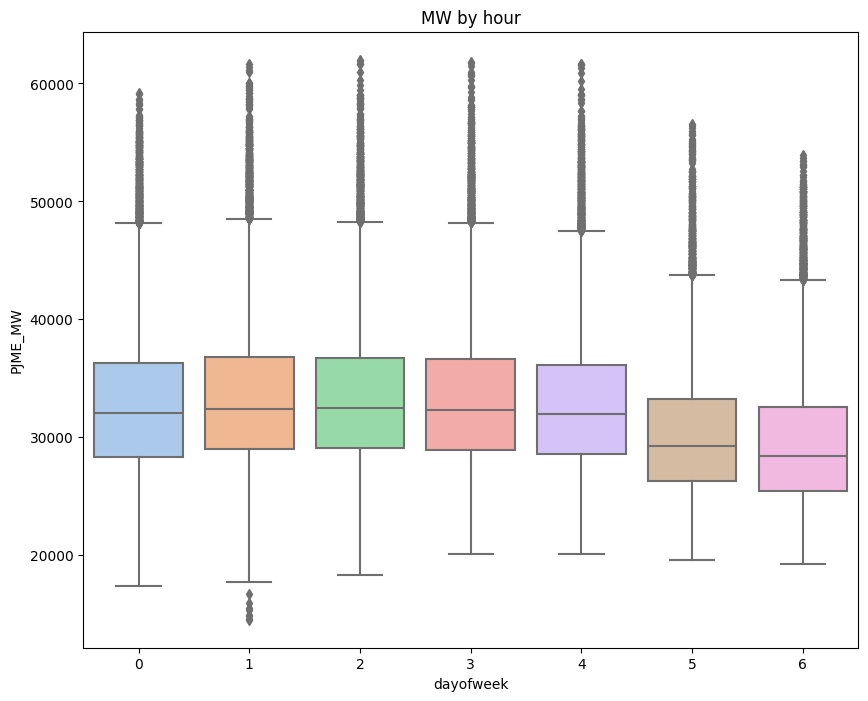

In [13]:
fig, ax = plt.subplots(figsize=(10,8))
sns.boxplot(data=df, x="dayofweek", y="PJME_MW", palette="pastel")
ax.set_title("MW by hour")
plt.show()

## Creating model

In [14]:
train = create_feature(train)
test = create_feature(test)

features = ['hour', 'dayofweek', 'quarter' , 'month', 'year', 'dayofyear']
target = 'PJME_MW'

In [15]:
X_train = train[features]
y_train = train[target]

X_test = test[features]
y_test = test[target]

In [16]:
reg = xgb.XGBRegressor(n_estimators=1000, early_stopping_rounds=50, learning_rate=0.01)
reg.fit(X_train, y_train, 
        eval_set=[(X_train, y_train),(X_test, y_test)],
        verbose=50)

[0]	validation_0-rmse:32601.87826	validation_1-rmse:31654.28935
[50]	validation_0-rmse:19921.59089	validation_1-rmse:18994.49302
[100]	validation_0-rmse:12342.17856	validation_1-rmse:11516.21767
[150]	validation_0-rmse:7889.60497	validation_1-rmse:7328.46143
[200]	validation_0-rmse:5373.20460	validation_1-rmse:5164.97392
[250]	validation_0-rmse:4033.40485	validation_1-rmse:4189.76215
[300]	validation_0-rmse:3375.48321	validation_1-rmse:3834.00707
[350]	validation_0-rmse:3066.02001	validation_1-rmse:3730.71565
[400]	validation_0-rmse:2884.85132	validation_1-rmse:3716.33146
[450]	validation_0-rmse:2771.93085	validation_1-rmse:3730.77469


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=1000, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

## feauture importance

In [17]:
feature_importance=pd.DataFrame(data=reg.feature_importances_,
             index=reg.feature_names_in_,
             columns=["importance"])

In [18]:
feature_importance

,importance
hour,0.448804
dayofweek,0.158668
quarter,0.033319
month,0.228156
year,0.022634
dayofyear,0.108419


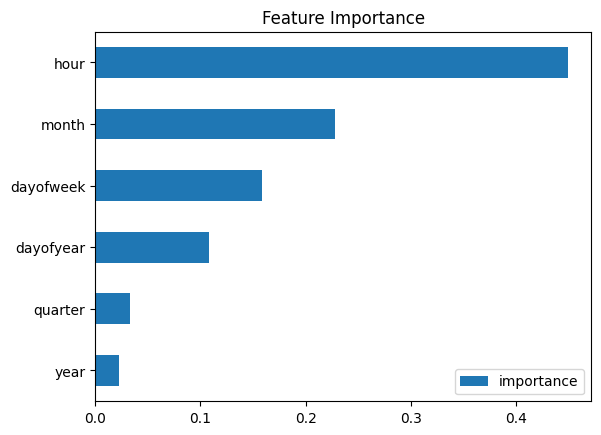

In [19]:
feature_importance.sort_values("importance").plot(kind='barh',title='Feature Importance')
plt.show()

In [20]:
test['prediction'] = reg.predict(X_test)
df = df.merge(test[['prediction']], how='left', left_index=True, right_index=True)

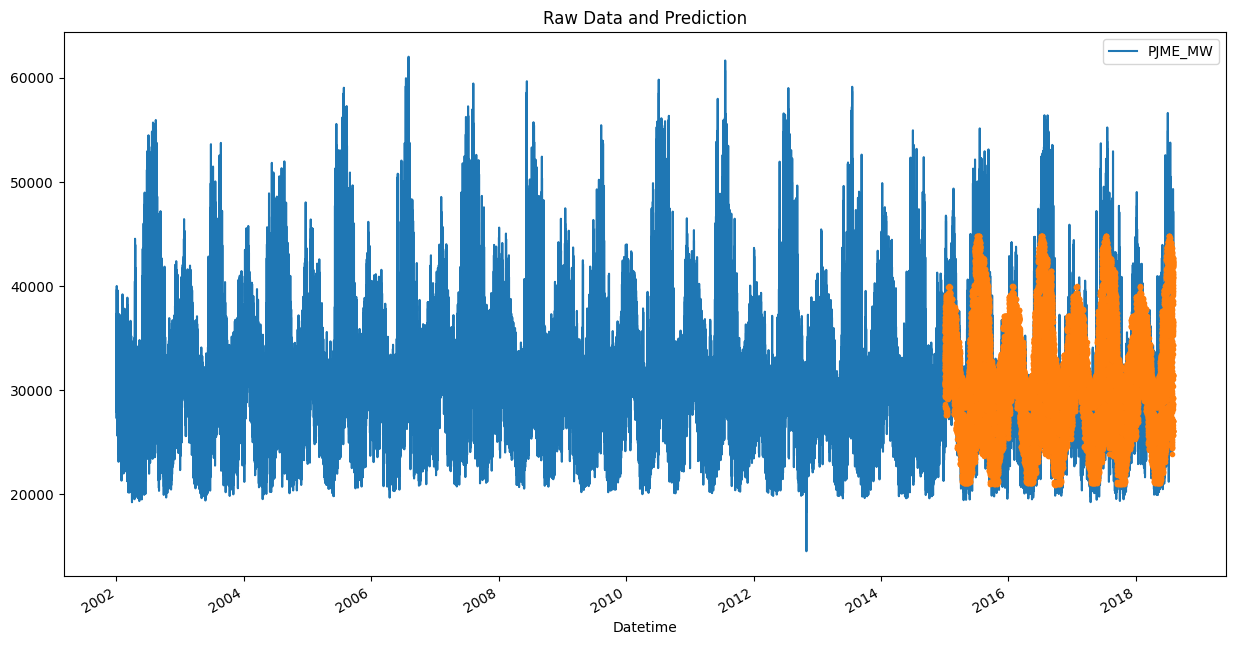

In [21]:
ax=df[['PJME_MW']].plot(figsize=(15,8))
df['prediction'].plot(ax=ax, style=".")
ax.set_title("Raw Data and Prediction")
plt.show()

In [28]:
df

,PJME_MW,hour,dayofweek,quarter,month,year,dayofyear,prediction
Datetime,,,,,,,,
2002-01-01 01:00:00,30393.0,1,1,1,1,2002,1,NaN
2002-01-01 02:00:00,29265.0,2,1,1,1,2002,1,NaN
2002-01-01 03:00:00,28357.0,3,1,1,1,2002,1,NaN
2002-01-01 04:00:00,27899.0,4,1,1,1,2002,1,NaN
2002-01-01 05:00:00,28057.0,5,1,1,1,2002,1,NaN
...,...,...,...,...,...,...,...,...
2018-08-02 20:00:00,44057.0,20,3,3,8,2018,214,40829.566406
2018-08-02 21:00:00,43256.0,21,3,3,8,2018,214,40358.277344
2018-08-02 22:00:00,41552.0,22,3,3,8,2018,214,39135.480469


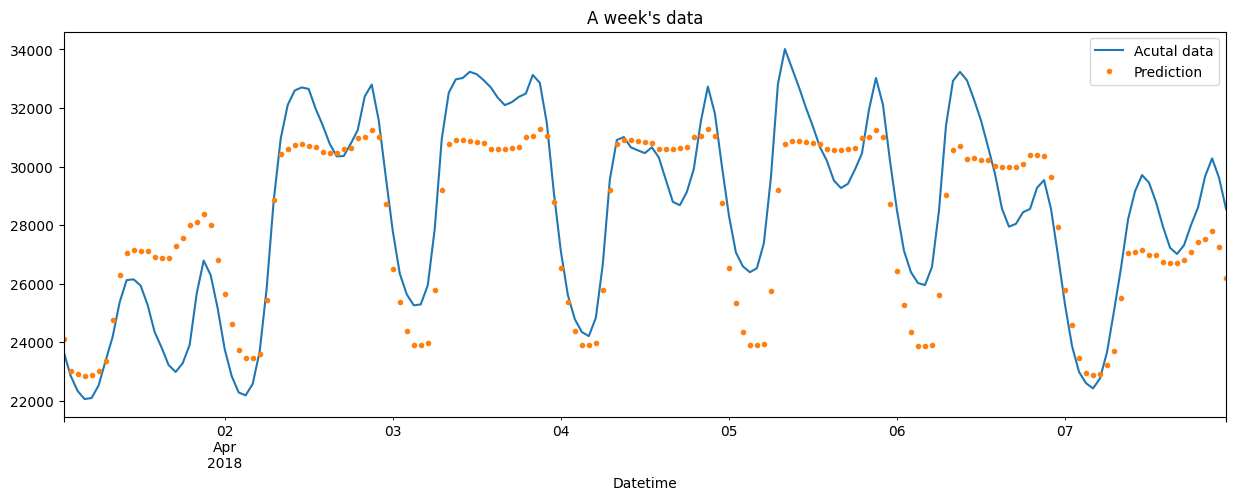

In [31]:
ax = df.loc[(df.index > "04-01-2018") & (df.index < "04-08-2018")]["PJME_MW"].plot(figsize=(15,5), title="A week's data")
df.loc[(df.index > "04-01-2018") & (df.index < "04-08-2018")]["prediction"].plot(style='.')
plt.legend(['Acutal data','Prediction'])
plt.show()

In [32]:
score = np.sqrt(mean_squared_error(test['PJME_MW'], test['prediction']))
print(f'RMSE Score on Test set: {score:0.2f}')

RMSE Score on Test set: 3715.93


In [34]:
test['error'] = np.abs(test[target] - test['prediction'])
test['date'] = test.index.date
test.groupby(['date'])['error'].mean().sort_values(ascending=False).head(10)

date
2016-08-13    14577.210124
2016-08-14    14472.472738
2016-09-10    12494.880941
2016-08-12    11525.418376
2016-09-09    11369.640299
2018-01-06    10903.514486
2015-02-20    10818.344727
2016-08-11    10390.962891
2018-01-07    10189.657715
2017-05-19    10180.837646
Name: error, dtype: float64

In [35]:
test.groupby(['date'])['error'].mean().sort_values(ascending=True).head(10)

date
2016-04-04    389.607829
2016-09-27    396.752116
2015-03-10    456.506510
2016-05-01    465.372640
2016-12-08    494.141764
2015-09-25    502.371094
2015-10-28    507.922445
2017-05-02    514.495768
2017-06-16    524.565267
2017-12-08    527.530436
Name: error, dtype: float64

- more robust cross validation
- add more features